In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
import torch
from torchvision import datasets, transforms

# 定义图片处理方法
transforms = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.ImageFolder("/content/drive/My Drive/many",
                               transform=transforms)

dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=16,
                                         shuffle=True,
                                         num_workers=2
                                         )

In [ ]:
from torch import nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d( 100, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netD = Discriminator()
netG = Generator()
criterion = nn.BCELoss()

lr = 0.0002
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

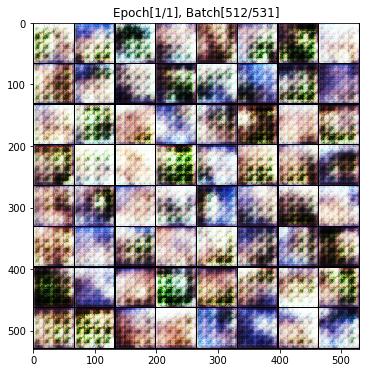

In [ ]:
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
from IPython import display
%matplotlib inline

epochs = 1
for epoch in range(epochs):
    for n, (images, _) in enumerate(dataloader):

        real_labels = torch.ones(images.size(0))
        fake_labels = torch.zeros(images.size(0))

        netD.zero_grad()
        output = netD(images)
        lossD_real = criterion(output.squeeze(), real_labels)

        noise = torch.randn(images.size(0), 100, 1, 1)
        fake_images = netG(noise)
        output2 = netD(fake_images.detach())
        lossD_fake = criterion(output2.squeeze(), fake_labels)
        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        netG.zero_grad()
        output3 = netD(fake_images)
        lossG = criterion(output3.squeeze(), real_labels)
        lossG.backward()
        optimizerG.step()

        fixed_noise = torch.randn(64, 100, 1, 1)
        fixed_images = netG(fixed_noise)
        fixed_images = make_grid(fixed_images.data,
                                 nrow=8, normalize=True).cpu()
        plt.figure(figsize=(6, 6))
        plt.title("Epoch[{}/{}], Batch[{}/{}]".format(epoch+1,
                                                      epochs,
                                                      n+1,
                                                      len(dataloader)))
        plt.imshow(fixed_images.permute(1, 2, 0).numpy())
        display.display(plt.gcf())
        display.clear_output(wait=True)